In [11]:
import numpy as np
import os
import rasterio 
from rasterio.plot import show, show_hist
import scipy
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
from shapely.geometry import Point, LineString, Polygon, box, shape
from rasterio.mask import mask
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling
from fiona.crs import from_epsg
from scipy.spatial import cKDTree
from rasterstats import zonal_stats
import fiona
import geocube
from rasterio import features
from pprintpp import pprint as pp


from project_functions import *


in_data_dir = r'.\data'

In [12]:
print("Running windfarm suitability analysis")
#avoid all existing easements (includes mostly pipeline and utility)
eas_Raster = rasterio.open(in_data_dir + './transmission_ras.tif', 'r')  
easments_arr = eas_Raster.read(1) 
suit_eas = np.where(easments_arr == 1, 0,1)

#avoid all oil and gas wells and platforms
oil_Raster = rasterio.open(in_data_dir + './oil_gas_assets_ras.tif', 'r')  
oil_arr = oil_Raster.read(1) 
suit_no_oil = np.where(oil_arr == 1, 0,1)

#avoid all existing leases
leases_Raster = rasterio.open(in_data_dir + './leases_ras.tif'  , 'r')  
coastal_arr = leases_Raster.read(1) 
suit_leases= np.where(coastal_arr == 1, 0, 1)

#avoid all navigation districts
navdist_Raster = rasterio.open(in_data_dir + './navdist_ras.tif'  , 'r')  
navdist_arr = navdist_Raster.read(1) 
suit_navdist= np.where(navdist_arr == 1, 0, 1)

#avoid all sensitive habitat
hab_Raster = rasterio.open(in_data_dir + './habitat_ras.tif'  , 'r')  
hab_arr = hab_Raster.read(1) 
suit_hab = np.where(hab_arr == 1, 0, 1)

#buildable depth for this analysis is between 0 and -50m
dem_raster =  rasterio.open(in_data_dir + './depth_ras.tif', 'r')  
dem_arr = dem_raster.read(1) 
dem_suit = np.where(dem_arr == 1, 1, 0)

#favorable wind speed criteria is > 7.5mph
speed_Wind_Raster = rasterio.open(in_data_dir + './wind_suit.tif', 'r')  
Wind_arr = speed_Wind_Raster.read(1) 
Suit_speed_wind = np.where(Wind_arr == 1, 1, 0)

#buffer created for a 4.4km, all values inside the buffer was given a zero
beach_buff_Raster = rasterio.open(in_data_dir + './beaches_buff.tif', 'r')  
beach_arr = beach_buff_Raster.read(1) 
suit_beach = np.where(beach_arr == 0, 0, 1)

#suitable site analysis 
sum_area = suit_eas + suit_no_oil + suit_leases + suit_navdist + suit_hab + Suit_speed_wind + dem_suit + suit_beach
suit_arr = np.where(sum_area == 8, 1, 0)


Running windfarm suitability analysis


In [13]:
#create meta variable for raster output
meta = speed_Wind_Raster.meta
meta.update({'dtype':'int32', 'nodata' : 0})

#export windfarm sites to raster
with rasterio.open(in_data_dir + './suit_windfarm.tif', 'w', **meta) as ds:
    ds.write_band(1, suit_arr)

In [14]:
print("Using shapely, polygonize raster created for windfarm sites")

#using shapely, polygonize raster the raster created for windfarm sites
with rasterio.open(in_data_dir + './suit_windfarm.tif', 'r') as src:
    data = src.read(1)

    mask = data != 0
    results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(features.shapes(data, connectivity=4, transform=src.transform, mask = mask)))
geoms = list(results)
df_suitability = gpd.GeoDataFrame.from_features(geoms)
df_suitability.crs = {'init': 'EPSG:26914'}
#create a shapefile for suitable sites using the polygonized raster
outfc = (in_data_dir + './suit_sites_UID.shp')
df_suitability.to_file(driver = 'ESRI Shapefile', filename = outfc)
shp = gpd.read_file(outfc)

Using shapely, polygonize raster created for windfarm sites


Total area of sites from this analysis is  311388
Total number of sites is 232 however we want a minimum area and therefore will perform zonal stats


<AxesSubplot:>

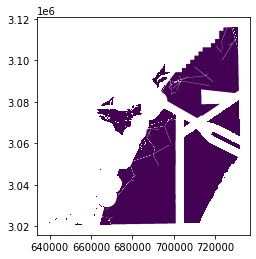

In [25]:
print('Total area of sites from this analysis is ', suit_arr.sum())
print('Total number of sites is', df_suitability['raster_val'].count(), 'however we want a minimum area and therefore will perform zonal stats')
df_suitability.plot(column='raster_val')


In [9]:
print("windfarm suitable sites zonal Stats Table")

#suitable sites were restricted to a depth of 0 to -50m 
#compute elevation statistics for each of the proposed windfarm sites (sites are greater than 60ha)
def get_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats)
    df = pd.DataFrame(result)
    return df

stats = get_zonal_stats(in_data_dir + './suit_sites_UID.shp' ,in_data_dir + './reproject_corpuschristi_dem.tif', stats=['mean', 'min', 'max', 'count'])
stats.to_csv(in_data_dir + './elevation_stats.csv')
stats[stats['count'] > 60]


windfarm suitable sites zonal Stats Table


,min,max,mean,count
0,-16.0,-12.0,-14.311475,305
1,-18.0,-12.0,-15.049310,1014
5,-4.0,-3.0,-3.926471,68
8,-4.0,-3.0,-3.090909,77
10,-4.0,-1.0,-3.303030,1023
28,-10.0,-6.0,-9.351351,111
33,-9.0,0.0,-2.334405,1866
36,0.0,0.0,0.000000,144
39,-4.0,-3.0,-3.681818,66
40,-4.0,-2.0,-3.647619,315


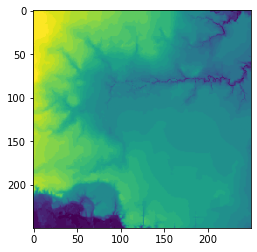

In [16]:
with rasterio.open(in_data_dir + './reproject_corpuschristi_dem.tif', 'r') as dem_file:
    dem = dem_file.read(1)
    dem_meta = dem_file.profile
    #set nodata values to nan
    show(dem[100:350,100:350])
    #resample dem using nearest neighbor
    s,a = slopeAspect(dem, 100)
    #recalculates the aspect to 8 cardinal directions using the fuction 
    aspect = reclassAspect(a)
    #using a bin size of 10, recalculate the slope grid into 10 classes using the function
    #s = reclassByHisto(s, 10)
    #print(s,a)


In [18]:
##compute minimum and maximum distance from the proposed windfarm site to existing windfarms
xs = []
ys = []
with open(os.path.join(in_data_dir, 'windfarm_locations.txt')) as coords:
    lines = coords.readlines()[1:]
    for l in lines:
        x,y = l.split(',')
        xs.append(float(x))
        ys.append(float(y))
    #np.vstack is for pixel data with height (first axis) width (second axis), concatenates along the first axis
    stations = np.vstack([xs, ys])
    stations = stations.T
    
with rasterio.open(os.path.join(in_data_dir, './suit_windfarm.tif')) as file:
    bounds = file.bounds
    
    topLeft = (bounds[0], bounds[3])
    lowRight = (bounds[2], bounds[1])
    cellSize = 100
    x_coords = np.arange(topLeft[0] + cellSize/2, lowRight[0], cellSize/2) #gives range of x coordinates
    y_coords = np.arange(lowRight[1] + cellSize/2, topLeft[1], cellSize/2) #gives range of y coordinates 
    #meshgrid cretaes a rectangular grid out of two given one-dim arrays reprenting cartesian indexing       
    x,y = np.meshgrid(x_coords, y_coords)
    #np.c_ tranlates slice objects to concatenation along the second axes, flatten returns the array in one dimension
    coord = (np.c_[x.flatten(), y.flatten()])

#provides an index into a set of k-dimensional points which can be used to rapidly look up the nearest neighbors of any point.
tree = cKDTree(coord)

#performs the nearest neighbor operations, with k being the nearest neighbors to return 
dd, ii = tree.query(stations, k=5)


print('The maximum distance to the closest existing windfarm site among all of the suitable sites is ' 
      +  str(dd.max()) + ' km')
print('The minimum distance to the closest existing windfarm site among all of the suitable sites is ' 
      +  str(dd.min()) + ' km')


The maximum distance to the closest existing windfarm site among all of the suitable sites is 77.15170796143595 km
The minimum distance to the closest existing windfarm site among all of the suitable sites is 6.323668701415338 km
